The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


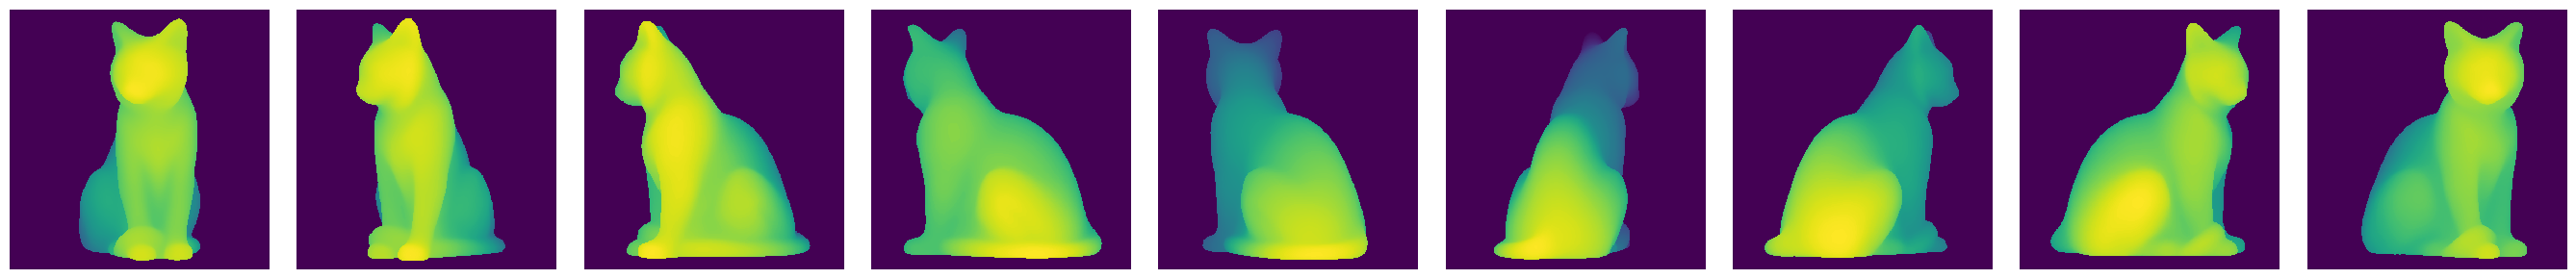

In [15]:
%load_ext autoreload
%autoreload 2
import os

os.chdir("/home/jorge/thesis")

from text3d2video.utilities.ipython_utils import display_ims

from text3d2video.artifacts.anim_artifact import AnimationArtifact
from text3d2video.rendering import render_depth_map
import torch

torch.set_grad_enabled(False)

animation_tag = "cat_statue_mv:latest"
animation = AnimationArtifact.from_wandb_artifact_tag(animation_tag)

verts_uvs, faces_uvs = animation.uv_data()

n_frames = 9
frame_indices = animation.frame_indices(9)
cameras, meshes = animation.load_frames(frame_indices)

depths = render_depth_map(meshes, cameras)
display_ims(depths)

In [16]:
from text3d2video.backprojection import (
    compute_texel_projections,
)

texture_res = 100
projections = compute_texel_projections(
    meshes, cameras, verts_uvs, faces_uvs, texture_res
)

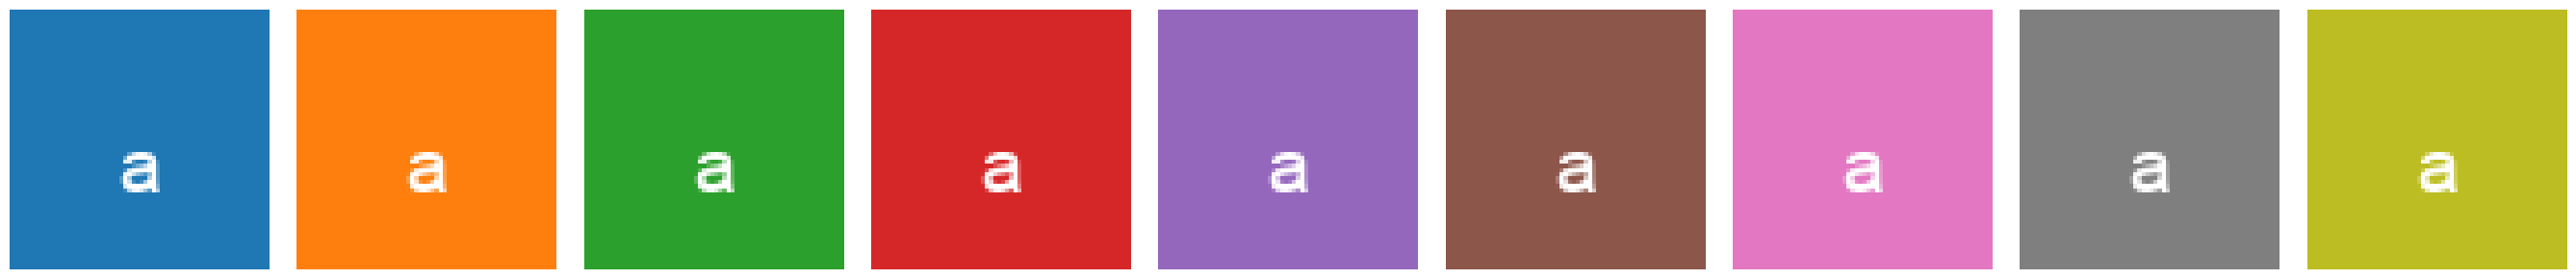

In [17]:
from matplotlib.cm import get_cmap
from text3d2video.utilities.testing_utils import test_img
import torchvision.transforms.functional as TF

CAMERA_RES = 64
cmap = get_cmap("tab10")

indices = torch.arange(n_frames)
colors = cmap(indices)

features_cond = [
    test_img(resolution=CAMERA_RES, color=colors[i][0:3], txt="a")
    for i in range(n_frames)
]
feature_maps = torch.stack([TF.to_tensor(img) for img in features_cond])

display_ims(features_cond)

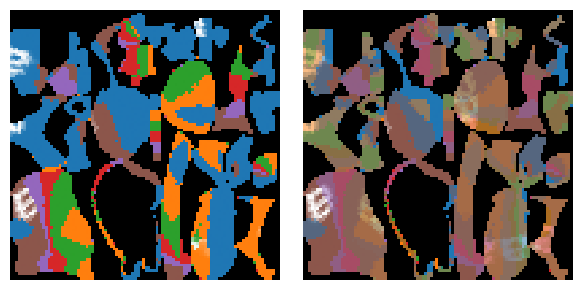

In [18]:
# frame_xy_coords
# frame_uv_coords

from text3d2video.backprojection import (
    aggregate_views_uv_texture,
    aggregate_views_uv_texture_mean,
)


n = 6
aggr_fmaps = feature_maps[0:n]
aggr_projections = projections[0:n]

uv_map_inpaint = aggregate_views_uv_texture(
    aggr_fmaps.cuda(), texture_res, aggr_projections
)

uv_map_mean = aggregate_views_uv_texture_mean(
    aggr_fmaps.cuda(), texture_res, aggr_projections
)

ims = [tex.cpu() for tex in [uv_map_inpaint, uv_map_mean]]
display_ims(ims)